**Preparing the environment.  Importing all the goodies.**

In [1]:
import re
import pandas as pd
import numpy as np
from pprint import pprint

# Get NLTK stopwords
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

# Import gensim goodies
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import spacy for lemmatization
import spacy
from spacy.lang.en import English

# Import plotting goodies
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fablabep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Set English stopwords**

In [2]:
stop_words = stopwords.words('english')

**Get dataset from file.  Drop rows lacking a classification code.**

In [3]:
source_file = '/home/fablabep/Downloads/renovation_labeled copy.csv'
reviews = pd.read_csv(source_file, sep='\t', error_bad_lines=False)[['text', 'Code']].dropna()

**Let's look at the data!**

In [4]:
reviews.head()

,text,Code
0,Our room was across a warren of stairs and rat...,1.0
1,The whole room was in urgent need of renovation .,1.0
2,Completely run down and in need of room renova...,1.0
3,Although ideally located but this needs lot of...,1.0
4,Having just spent the previous 5 days of my vi...,1.0


**Data contains some review text and a code corresponding to: 1 = Needs Renovation; 2 = Currently Renovating; 3 = Recently Renovated.**

**Set English as language for lemmatization**

In [5]:
spacy.load('en')

**Preprocess review text**

In [6]:
reviews_processed = [gensim.utils.simple_preprocess(sentence, deacc=True) for sentence in reviews['text']]

**Generate bigram and trigram models for preprocessing text.  This should reduce the number of features used later for training models.**

In [7]:
bigram = gensim.models.Phrases(reviews_processed, min_count=3, threshold=30)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[reviews_processed], threshold=30)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/home/fablabep/anaconda3/envs/capstone/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


**Set up some functions to remove stopwords, make bigrams & trigrams, and lemmatize the preprocessed text from reviews**

In [8]:
def remove_stopwords(reviews):
    return [[word for word in review if word not in stop_words] for review in reviews]

def make_bigrams(reviews):
    return [bigram_mod[review] for review in reviews]

def make_trigrams(reviews):
    return [trigram_mod[bigram_mod[review]] for review in reviews]

def lemmatization(reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    reviews_out = []
    for review in reviews:
        doc = nlp(" ".join(review))
        #reviews_out.append([token.lemma_ for token in doc])
        reviews_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) #filters POS tags
    return reviews_out

**Finish up pre-processing**

In [9]:
nlp = spacy.load('en', disable=['parser', 'ner'])

reviews_processed_nostops = remove_stopwords(reviews_processed)

reviews_processed_bigrams = make_bigrams(reviews_processed_nostops)

reviews_processed_trigrams = make_trigrams(reviews_processed_bigrams)

reviews_lemmatized = lemmatization(reviews_processed_trigrams)

**Let's look at a lemmatized review!**

In [10]:
print(reviews_lemmatized[0])

['room', 'warren', 'stair', 'rat', 'run', 'arrive', 'heart', 'sink', 'dark', 'dingy', 'bathroom', 'last', 'renovate', 'late', 'look', 'state']


**Let's start building a corpus from the lemmatized review text.  Start by assigning each word an integer ID.**

In [11]:
id2word = corpora.Dictionary(reviews_lemmatized)

**Filter out common and rare words from the corpus**

In [12]:
id2word.filter_extremes(no_below=10, no_above=0.7)

**Convert each review into bag of words**

In [13]:
corpus = [id2word.doc2bow(review) for review in reviews_lemmatized]

In [14]:
len(id2word)

971

**Let's take a look at a processed review and the frequency of occurence for each word**

In [15]:
[[(id2word[id], freq) for id, freq in word] for word in corpus[:1]]

[[('arrive', 1),
  ('bathroom', 1),
  ('dark', 1),
  ('last', 1),
  ('late', 1),
  ('look', 1),
  ('renovate', 1),
  ('room', 1),
  ('run', 1),
  ('sink', 1),
  ('stair', 1),
  ('state', 1)]]

**Function to compute coherence values for LDA models to help pick the optimal number of topics**

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunk_size,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

**Set some values for generating LDA topic models**

In [17]:
limit = 100
start = 60
step = 10
chunk_size = len(corpus)/20

**Generate the LDA topic models and plot coherence as a function of number of topics**

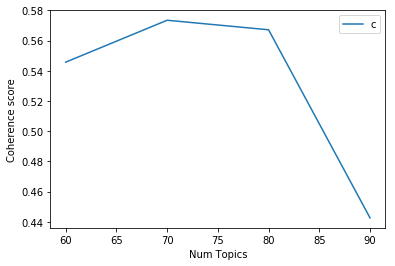

In [346]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=reviews_lemmatized, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**Select the model with greatest coherence**

In [347]:
lda_model = model_list[1]

**Print the coherence of the selected model**

In [348]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.573509409858555


**Let's visualize the topics in the selected model**

In [20]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)

pyLDAvis.display(lda_display)

/home/fablabep/anaconda3/envs/capstone/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**Save the LDA topic model**

In [350]:
lda_model.save('lda_model_70_topics')

**Optionally load a saved model**

In [19]:
lda_model = gensim.models.ldamodel.LdaModel.load('lda_model_70_topics')

**Function to get topic scores for each review**

In [27]:
def get_topic_scores(model, dictionary, reviews):
    topic_scores = [model.get_document_topics(dictionary.doc2bow(review)) for review in reviews]
    return topic_scores

**Get the topic scores for lemattized reviews generated earlier.  Use the scores to build dictionaries for each review where keys are topic numbers and values are the corresponding score.**

In [352]:
review_topic_scores = get_topic_scores(model=lda_model, dictionary=id2word, reviews=reviews_lemmatized)
review_topic_scores_dict = [dict(score) for score in review_topic_scores]

**Turn the review scores for each review into training set for classifiers.  Replace empty values with zeros.**

In [353]:
X = pd.DataFrame(review_topic_scores_dict).fillna(0)

**Now we have some trainable features.  Let's take a look.**

In [354]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169400,0.022165,0.015949,...,0.0,0.040574,0.010464,0.016986,0.000000,0.0,0.0,0.012960,0.00000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027459,0.019757,...,0.0,0.016147,0.012963,0.021042,0.011313,0.0,0.0,0.016055,0.01011,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036766,0.025705,0.018495,...,0.0,0.015116,0.012135,0.019698,0.010590,0.0,0.0,0.046966,0.00000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.023457,0.016878,...,0.0,0.013794,0.011074,0.017976,0.000000,0.0,0.0,0.013715,0.00000,0.030821
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.022793,0.016400,...,0.0,0.013403,0.039080,0.017467,0.000000,0.0,0.0,0.013327,0.00000,0.000000


**Let's look at the descriptive stats for each topic score**

In [355]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
count,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,...,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000,7198.000000
mean,0.001912,0.002638,0.003467,0.001384,0.005746,0.002264,0.002784,0.001745,0.032617,0.023174,...,0.002672,0.018814,0.014707,0.025377,0.010754,0.002098,0.003007,0.019018,0.006722,0.001007
std,0.008229,0.009958,0.011397,0.006786,0.012522,0.009020,0.010427,0.007902,0.015776,0.012978,...,0.009818,0.012191,0.012341,0.014426,0.011933,0.008947,0.010625,0.012025,0.011647,0.005722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024162,0.017385,...,0.000000,0.014208,0.011407,0.018515,0.000000,0.000000,0.000000,0.014127,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026553,0.019106,...,0.000000,0.015614,0.012535,0.020348,0.010940,0.000000,0.000000,0.015525,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.010130,0.000000,0.000000,0.000000,0.029470,0.020455,...,0.000000,0.016717,0.013421,0.022583,0.011713,0.000000,0.000000,0.016622,0.010467,0.000000
max,0.089998,0.112394,0.156594,0.087900,0.159922,0.142714,0.204823,0.169400,0.217327,0.142062,...,0.150110,0.185388,0.131485,0.193178,0.089291,0.139233,0.113793,0.164871,0.141949,0.075847


**Let's look at the distribution of scores for each topic**

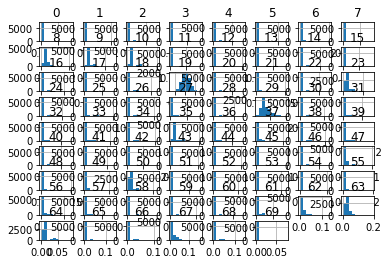

In [356]:
X.hist()
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from time import time

**Function to report results from grid search**

In [23]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

**Let's try training some Random Forest Classifiers on the features and use Grid Search to find the best parameters**

In [24]:
clf = RandomForestClassifier(random_state=42)
target = reviews['Code']

In [185]:
X = pd.DataFrame(review_topic_scores_dict).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), target, test_size=0.15, random_state=42)
param_grid = {"n_estimators": [200, 300],
              "min_samples_split": [2, 5, 10],
              "max_features": ['sqrt', 'log2'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 557.00 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.713 (std: 0.009)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.711 (std: 0.007)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.711 (std: 0.007)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 300}



**The mean validation score of the best model (0.713) is already better than the baseline model!!!  Let's see where the mistakes are happening using a confusion matrix.**

In [186]:
best_clf = grid_search.best_estimator_
print(confusion_matrix(y_test, best_clf.predict(X_test)))

[[119  31 100]
 [ 29 154  99]
 [ 22  69 457]]


**Looks like each category was "mostly" predicted correctly, but they each have a LOT of errors, especially category "1" representing rooms that need renovation.  Recently renovated rooms look like they are easiest to predict.  Let's try another approach.  Maybe scaling the data first will improve the validation score.**  

In [187]:
scaler = StandardScaler()
X = pd.DataFrame(review_topic_scores_dict).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(scaler.fit_transform(X)), target, test_size=0.15, random_state=42)
param_grid = {"n_estimators": [200, 300],
              "min_samples_split": [2, 5, 10],
              "max_features": ['sqrt', 'log2'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 567.82 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.712 (std: 0.010)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.712 (std: 0.009)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.711 (std: 0.009)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 200}



**The validation score did NOT improve with scaling of the features.  Let's look at the confusion matrix again.**

In [188]:
best_clf = grid_search.best_estimator_
print(confusion_matrix(y_test, best_clf.predict(X_test)))

[[122  30  98]
 [ 26 160  96]
 [ 21  68 459]]


**The confusion matrix looks pretty similar.  No major changes here.  Let's try another approach.  Maybe running PCA on the scaled features will help because some of the topic scores are likely to be correlated judging by the LDA visualization.**

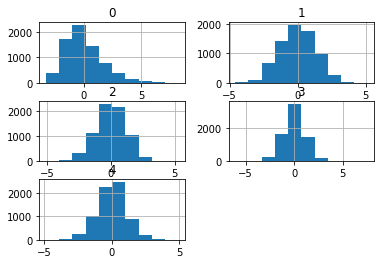

In [189]:
scaler = StandardScaler()
pca = PCA(n_components=5)
X = pd.DataFrame(review_topic_scores_dict).fillna(0)
X_pca = pca.fit_transform(scaler.fit_transform(X))
                  
pd.DataFrame(X_pca).hist()
plt.show()

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.15, random_state=42)
param_grid = {"n_estimators": [200, 300],
              "min_samples_split": [2, 5, 10],
              "max_features": ['sqrt', 'log2'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 760.96 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.636 (std: 0.009)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}

Model with rank: 1
Mean validation score: 0.636 (std: 0.009)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.636 (std: 0.011)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.636 (std: 0.011)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 200}



**The validation score actually decreased quite a bit here.  Let's abandon this approach.**

**Let's try feature selection using a RFC with the parameters we found in the first grid search.**

In [418]:
from sklearn.feature_selection import SelectFromModel

X = pd.DataFrame(review_topic_scores_dict).fillna(0)
rfc = SelectFromModel(RandomForestClassifier(bootstrap = True,
                             criterion = 'gini',
                             max_features = 'log2',
                             min_samples_split = 10,
                             n_estimators = 200,
                             random_state = 42))

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.15, random_state=42)

rfc.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [419]:
best_feat = list(X_train.columns[(rfc.get_support())])
print(best_feat)

X_train_selected = X_train[best_feat]
X_test_selected = X_test[best_feat]

[8, 9, 10, 19, 23, 29, 35, 39, 47, 49, 50, 56, 57, 60, 61, 62, 63, 67]


**Grid search RFC using only the selected features**

In [420]:
param_grid = {"n_estimators": [200, 300],
              "min_samples_split": [2, 5, 10],
              "max_features": ['sqrt', 'log2'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_train_selected, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 456.91 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.695 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 1
Mean validation score: 0.695 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.695 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.695 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 300}



**Get accuracy of new model on test set**

In [423]:
rfc_selected = grid_search.best_estimator_
rfc_selected.score(X_test_selected, y_test)

0.6555555555555556

**Oh no!  Accuracy decreased from 0.713 to 0.656 after feature selection.**

**Let's try another type of classifier: AdaBoost**

In [221]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2))

**Let's try the same datasets: X, X_std, X_pca and selected features**

In [228]:
param_grid = {"n_estimators": [100, 150, 250, 500],
             "learning_rate": [0.01, 0.05, 0.1, 0.3]
             }

grid_search = GridSearchCV(adb, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 151.50 seconds for 16 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.697 (std: 0.005)
Parameters: {'learning_rate': 0.05, 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.697 (std: 0.004)
Parameters: {'learning_rate': 0.1, 'n_estimators': 250}

Model with rank: 3
Mean validation score: 0.695 (std: 0.005)
Parameters: {'learning_rate': 0.1, 'n_estimators': 150}



**Not too bad.  Similar accuracy as the Random Forest Classifier, but not quite as good.  Let's try the scaled features.**

In [229]:
param_grid = {"n_estimators": [100, 150, 250, 500],
             "learning_rate": [0.01, 0.05, 0.1, 0.3]
             }

grid_search = GridSearchCV(adb, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(pd.DataFrame(scaler.fit_transform(X_train)), y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 152.41 seconds for 16 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.698 (std: 0.005)
Parameters: {'learning_rate': 0.05, 'n_estimators': 250}

Model with rank: 2
Mean validation score: 0.697 (std: 0.004)
Parameters: {'learning_rate': 0.05, 'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.697 (std: 0.008)
Parameters: {'learning_rate': 0.3, 'n_estimators': 100}



**Let's check the confusion matrix**

In [230]:
best_adb = grid_search.best_estimator_
print(confusion_matrix(y_test, best_adb.predict(scaler.fit_transform(X_test))))

[[116  40  94]
 [ 31 151 100]
 [ 24  76 448]]


**OK...no improvement here over Random Forest Classifier.  Let's try the PCA one more time.**

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.15, random_state=42)
param_grid = {"n_estimators": [100, 150, 250, 500],
             "learning_rate": [0.01, 0.05, 0.1, 0.3]
             }

grid_search = GridSearchCV(adb, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 113.32 seconds for 16 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.634 (std: 0.007)
Parameters: {'learning_rate': 0.1, 'n_estimators': 150}

Model with rank: 2
Mean validation score: 0.633 (std: 0.005)
Parameters: {'learning_rate': 0.1, 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.631 (std: 0.010)
Parameters: {'learning_rate': 0.05, 'n_estimators': 100}



**Check the confusion matrix one more time**

In [233]:
best_adb = grid_search.best_estimator_
print(confusion_matrix(y_test, best_adb.predict(scaler.fit_transform(X_test))))

[[ 57  72 121]
 [ 27 115 140]
 [ 18  53 477]]


**Seems like Random Forest Classifier trained on the unscaled topic scores as features still gives the best performance.  Let's see if we can do better than 0.713 validation accuracy using Artificial Neural Networks.**

**Import Keras goodies for ANNs**

In [31]:
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint

**Let's get some new training and testing data splits**

In [358]:
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.15, random_state=42)

**Adjust the category values from 1-3 to 0-2**

In [359]:
y_train = [int(category-1) for category in y_train]
y_test = [int(category-1) for category in y_test]

**Categorically encode the targets and cast everything to numpy arrays**

In [360]:
num_classes = 3
y_train = np.array(keras.utils.to_categorical(y_train, num_classes))
y_test = np.array(keras.utils.to_categorical(y_test, num_classes))
X_train = np.array(X_train)
X_test = np.array(X_test)

**Let's build a Deep Neural Network.  Played around with a lot of different architectures and this one seemed to train OK.  There are likely to be better architectures out there.**

In [361]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(70,)))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.1))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.1))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 128)               9088      
_________________________________________________________________
batch_normalization_68 (Batc (None, 128)               512       
_________________________________________________________________
dropout_91 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 32)                4128      
_________________________________________________________________
batch_normalization_69 (Batc (None, 32)                128       
_________________________________________________________________
dropout_92 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 8)                 264       
__________

**Let's train the model and save the weights for the best one along the way.  Best one is the model with greatest validation accuracy in a run.**

In [362]:
filepath = 'weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit(X_train, y_train, validation_split=0.3, epochs=50, batch_size=500, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_acc improved from -inf to 0.54684, saving model to weights.best.hdf5

Epoch 00002: val_acc improved from 0.54684 to 0.58606, saving model to weights.best.hdf5

Epoch 00003: val_acc improved from 0.58606 to 0.61057, saving model to weights.best.hdf5

Epoch 00004: val_acc improved from 0.61057 to 0.63780, saving model to weights.best.hdf5

Epoch 00005: val_acc improved from 0.63780 to 0.65468, saving model to weights.best.hdf5

Epoch 00006: val_acc improved from 0.65468 to 0.66122, saving model to weights.best.hdf5

Epoch 00007: val_acc did not improve from 0.66122

Epoch 00008: val_acc improved from 0.66122 to 0.66285, saving model to weights.best.hdf5

Epoch 00009: val_acc did not improve from 0.66285

Epoch 00010: val_acc did not improve from 0.66285

Epoch 00011: val_acc did not improve from 0.66285

Epoch 00012: val_acc did not improve from 0.66285

Epoch 00013: val_acc did not improve from 0.66285

Epoch 00014: val_acc improved from 0.66285 to 0.66449, saving mode

**Best validation accuracy achieved on by this model was only 0.69880.  That's worse than the Random Forest Classifier!  Let's see if this can be improved.  But first, let's check performance on the test data set.**

In [363]:
best_model = Sequential()
best_model.add(Dense(128, activation='relu', input_shape=(70,)))
best_model.add(BatchNormalization())
best_model.add(Dropout(.2))
best_model.add(Dense(32, activation='relu'))
best_model.add(BatchNormalization())
best_model.add(Dropout(.1))
best_model.add(Dense(8, activation='relu'))
best_model.add(BatchNormalization())
best_model.add(Dropout(.1))
best_model.add(Dense(3, activation='softmax'))
best_model.load_weights('weights.best.hdf5')
best_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Now we have a new model compiled using the best weights from the prior run.  Let's see how it predicts the targets using the features from the test data set**

In [364]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: ", score[1])

Accuracy:  0.6583333333333333


**A function to get IDs from the already generated corpus**

In [17]:
def get_ids(corpus):
    entries = []
    for entry in corpus:
        items = []
        for item in entry:
            items.append(item[0])
        entries.append(items)
    return entries

**Let's re-load the lemmatized reviews as a starting point**

In [18]:
X = reviews_lemmatized

**Import some more Keras goodies to tokenize the lemmatized reviews.  Keep only 1000 words after tokenization**

In [19]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [20]:
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)

**Let's get a new train / test split from the tokenized reviews**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

**Get the topic scores for the X_train and X_test reviews.  These can be concatenated with the one-hot encodings later.**

In [69]:
X_train_topics = get_topic_scores(model=lda_model, dictionary=id2word, reviews=X_train)
X_test_topics = get_topic_scores(model=lda_model, dictionary=id2word, reviews=X_test)
X_train_topic_scores = pd.DataFrame([dict(score) for score in X_train_topics]).fillna(0)
X_test_topic_scores = pd.DataFrame([dict(score) for score in X_test_topics]).fillna(0)

NameError: name 'lda_model' is not defined

**Convert X_train and X_test reviews into corpora and get the word ids for each review**

In [70]:
X_train = get_ids([id2word.doc2bow(review) for review in X_train])
X_test = get_ids([id2word.doc2bow(review) for review in X_test])

**One-hot encode each lemmatized review**

In [71]:
X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')

**Concatenate the one-hot encoded features with the topic scores.  Can be used as an augmented feature set.**

In [72]:
X_train_concat = np.concatenate((X_train, X_train_topic_scores), axis=1)
X_test_concat = np.concatenate((X_test, X_test_topic_scores), axis=1)

NameError: name 'X_train_topic_scores' is not defined

**Categorically encode the targets and cast everything to numpy arrays**

In [73]:
num_classes = 3
y_train = [int(category-1) for category in y_train]
y_test = [int(category-1) for category in y_test]
y_train = np.array(keras.utils.to_categorical(y_train, num_classes))
y_test = np.array(keras.utils.to_categorical(y_test, num_classes))

**Build a new model to train on the one-hot encoded features**

In [402]:
model_one_hot = Sequential()
model_one_hot.add(Dense(128, activation='relu', input_shape=(num_words,), kernel_regularizer=regularizers.l2(0.01)))
model_one_hot.add(Dropout(.1))
model_one_hot.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_one_hot.add(BatchNormalization())
model_one_hot.add(Dropout(.1))
model_one_hot.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_one_hot.add(BatchNormalization())
model_one_hot.add(Dropout(.1))
model_one_hot.add(Dense(3, activation='softmax'))
model_one_hot.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_one_hot.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 128)               128128    
_________________________________________________________________
dropout_127 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 32)                4128      
_________________________________________________________________
batch_normalization_94 (Batc (None, 32)                128       
_________________________________________________________________
dropout_128 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_171 (Dense)            (None, 8)                 264       
_________________________________________________________________
batch_normalization_95 (Batc (None, 8)                 32        
__________

**Train the new model using checkpointing to save the best weights**

In [403]:
filepath = 'weights.best_one_hot.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model_one_hot.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=100, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_acc improved from -inf to 0.72123, saving model to weights.best_one_hot.hdf5

Epoch 00002: val_acc improved from 0.72123 to 0.76290, saving model to weights.best_one_hot.hdf5

Epoch 00003: val_acc improved from 0.76290 to 0.78671, saving model to weights.best_one_hot.hdf5

Epoch 00004: val_acc did not improve from 0.78671

Epoch 00005: val_acc improved from 0.78671 to 0.79464, saving model to weights.best_one_hot.hdf5

Epoch 00006: val_acc did not improve from 0.79464

Epoch 00007: val_acc did not improve from 0.79464

Epoch 00008: val_acc did not improve from 0.79464

Epoch 00009: val_acc did not improve from 0.79464

Epoch 00010: val_acc did not improve from 0.79464

Epoch 00011: val_acc did not improve from 0.79464

Epoch 00012: val_acc did not improve from 0.79464

Epoch 00013: val_acc did not improve from 0.79464

Epoch 00014: val_acc did not improve from 0.79464

Epoch 00015: val_acc did not improve from 0.79464

Epoch 00016: val_acc did not improve from 0.79464

**Load the best weights and use the trained model to predict test targets from test features**

In [74]:
best_model_one_hot = Sequential()
best_model_one_hot.add(Dense(128, activation='relu', input_shape=(num_words,), kernel_regularizer=regularizers.l2(0.02)))
best_model_one_hot.add(Dropout(.1))
best_model_one_hot.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
best_model_one_hot.add(BatchNormalization())
best_model_one_hot.add(Dropout(.1))
best_model_one_hot.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
best_model_one_hot.add(BatchNormalization())
best_model_one_hot.add(Dropout(.1))
best_model_one_hot.add(Dense(3, activation='softmax'))
best_model_one_hot.load_weights('weights.best_one_hot.hdf5')
best_model_one_hot.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
score = best_model_one_hot.evaluate(X_test, y_test, verbose=0)
print("Accuracy: ", score[1])

Accuracy:  0.7722222222222223


**Not bad after only 150 epochs.  More training might yield higher accuracy, but this is already a great improvement over the baseline model.**

In [77]:
y_predicted = best_model_one_hot.predict(X_test)
print(confusion_matrix(np.argmax(y_test, 1), np.argmax(y_predicted, 1)))

[[ 288   67  146]
 [  29  340  148]
 [  26   76 1040]]


**Let's revisit Random Forest Classifier using the one-hot encoded reviews**

In [80]:
param_grid = {"n_estimators": [200, 300],
              "min_samples_split": [2, 5, 10],
              "max_features": ['sqrt', 'log2'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 1167.57 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.740 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.739 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.739 (std: 0.009)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}



**Looks like a slight improvement over using the topic models, but the Deep Neural Network still wins out.**

In [81]:
best_clf_one_hot = grid_search.best_estimator_
y_predicted = best_clf_one_hot.predict(X_test)

In [82]:
print(confusion_matrix(np.argmax(y_test, 1), np.argmax(y_predicted, 1)))

[[367  28 106]
 [110 304 103]
 [ 91  63 988]]


In [84]:
best_clf_one_hot.score(X_test, y_test)

0.7351851851851852